## Importación de librerías

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd())) # Change working directory to parent directory

In [2]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from test_harness.datasets.dataset import Dataset
from test_harness.experiments._1_baseline_experiment import BaselineExperiment
from test_harness.experiments._2_response_uncertainty_experiment import UncertaintyKSExperiment
from test_harness.experiments._3_margin_uncertainty_experiment import UncertaintyX2Experiment
from test_harness.experiments._4_margin_threshold_experiment import MarginThresholdExperiment
from test_harness.experiments._5_topline_experiment import ToplineExperiment

from test_harness.utils.utils import (
    plot_experiment_error,
    aggregate_experiment_metrics,
    plot_KS_drift_distributions,
    plot_XS_drift_margin_distributions
)

import matplotlib.pyplot as plt

%matplotlib inline

## Preparación de los experimentos

In [3]:
def define_run_exps(model, param_grid, dataset, delete_csv=False):

    exps = []

    # baseline experiment
    baseline = BaselineExperiment(model=model, dataset=dataset, param_grid=param_grid, delete_csv=delete_csv)
    baseline.run()
    exps.append(baseline)

    # response uncertainty experiment
    uncertainty_ks = UncertaintyKSExperiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        significance_thresh=0.01,
        delete_csv=delete_csv
    )
    uncertainty_ks.run()
    exps.append(uncertainty_ks)
    
    # margin uncertainty experiment
    uncertainty_x2 = UncertaintyX2Experiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        significance_thresh=0.01,
        margin_width=0.15,
        delete_csv=delete_csv
    )
    uncertainty_x2.run()
    exps.append(uncertainty_x2)
    
    # margin threshold experiment
    margin_threshold = MarginThresholdExperiment(
        model=model,
        dataset=dataset,
        param_grid=param_grid,
        k=5,
        margin_width=0.2,
        sensitivity=1.5,
        delete_csv=delete_csv
    )
    margin_threshold.run()
    exps.append(margin_threshold)

    # topline experiment
    topline = ToplineExperiment(
        model=model,
        dataset=dataset,
        k=5,
        param_grid=param_grid,
        delete_csv=delete_csv
    )
    topline.run()
    exps.append(topline)
    
    return exps

## Carga de datos y ejecución de experimentos

### SEA - abrupto

In [4]:
# Load data
change_points = [10000]

column_mapping = {
    "target": "target",
    "int_features": ["v", "w", "x"],
    "float_features": [],
}

dataset_SEA_abr = pd.read_csv("./datasets/data_SEA_abrupto.csv")
name_ds = "exp_results/data_SEA_abrupto"

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


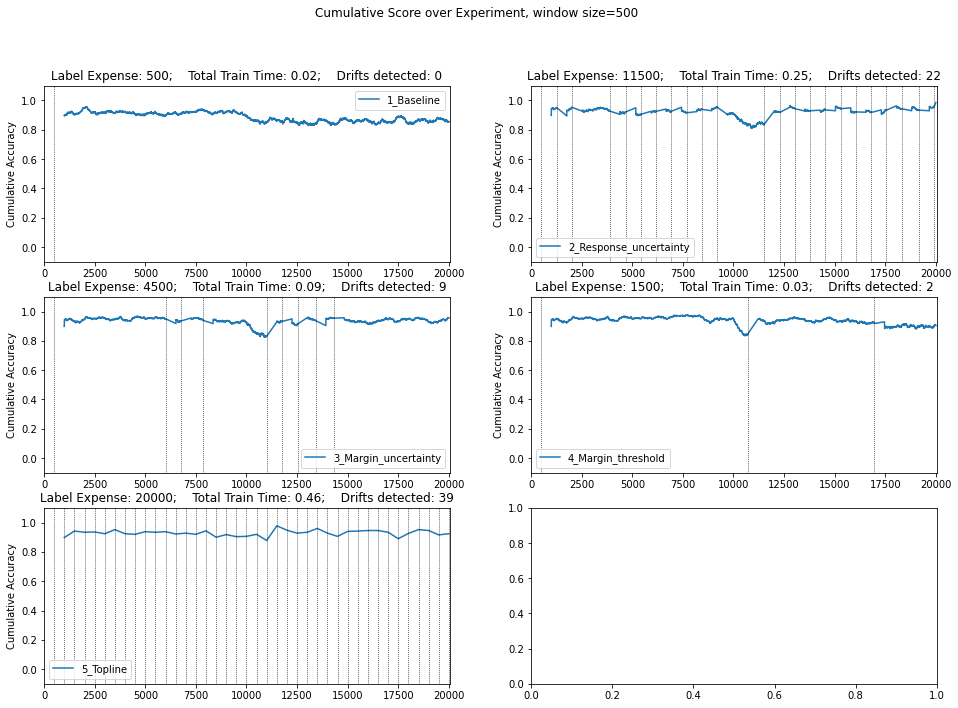

Running experiments with window size = 1500


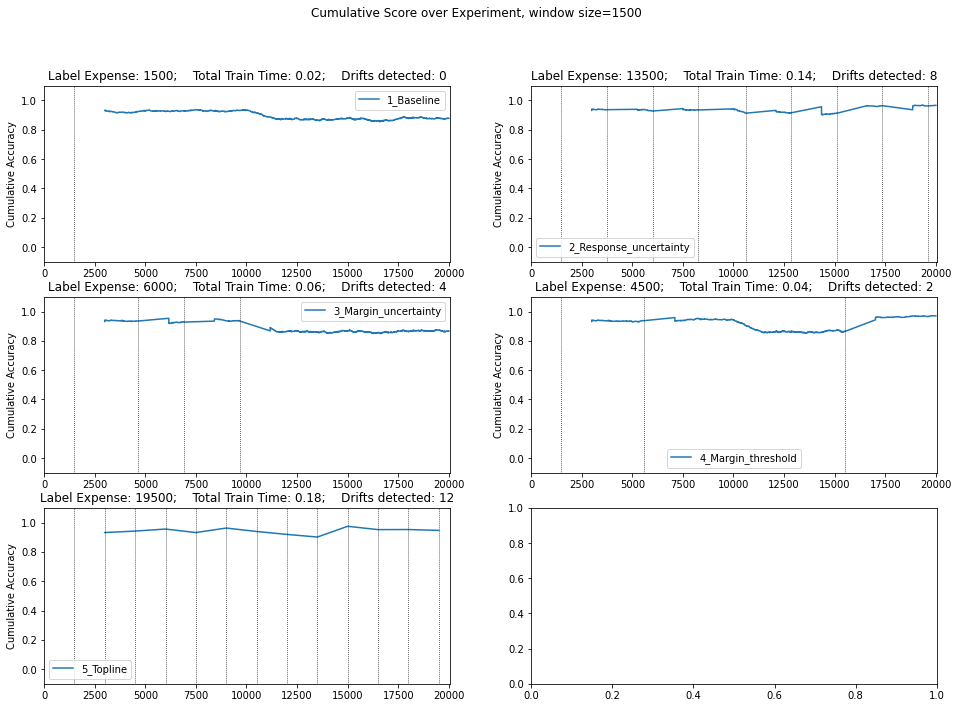

Running experiments with window size = 2500


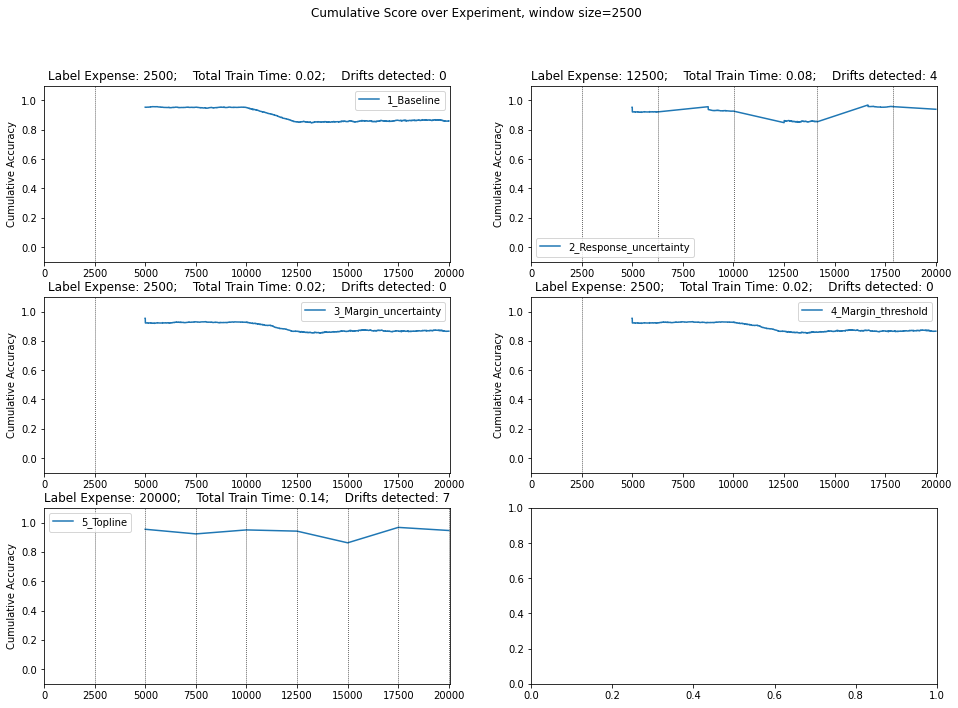

In [5]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500]:
    # Define dataset
    dataset = Dataset(name_ds, full_df=dataset_SEA_abr, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset.window_size}")
    exps = define_run_exps(model, param_grid, dataset, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset.window_size}")
    plt.show()

##### Consolidación de métricas

In [5]:
metrics = []

exps = ["2_Response_uncertainty", "3_Margin_uncertainty", "4_margin_threshold"]

for exp in exps:
    str_res = f"./results/{name_ds}_{exp}_results.csv"
    results = pd.read_csv(str_res, sep=",", low_memory=False)

    for type_eval in ["Strict", "Medium", "Relaxed"]:
        metrics = aggregate_experiment_metrics(metrics, results, change_points, [500, 1500, 2500], type_eval)

pd.DataFrame(metrics).set_index(['Experiment','Evaluation','Window sizes'])

Drift signaled  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                       22   
                                  1500                       8   
                                  2500                       4   
                       Medium     500                       22   
                                  1500                       8   
                                  2500                       4   
                       Relaxed    500                       22   
                                  1500                       8   
                                  2500                       4   
3_Margin_uncertainty   Strict     500                        9   
                                  1500                       4   
                                  2500                       0   
                       Medium     500                        9   
                                  1500                       4   
                                  2500                       0   
                       Relaxed    500                        9   
                                  1500                       4   
                                  2500                       0   
4_Margin_threshold     Strict     500                        2   
                                  1500                       2   
                                  2500                       0   
                       Medium     500                        2   
                                  1500                       2   
                                  2500                       0   
                       Relaxed    500                        2   
                                  1500                       2   
                                  2500                       0   

                                                Drift occurred  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   
3_Margin_uncertainty   Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   
4_Margin_threshold     Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   

                                                True positives  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        0   
                    

##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


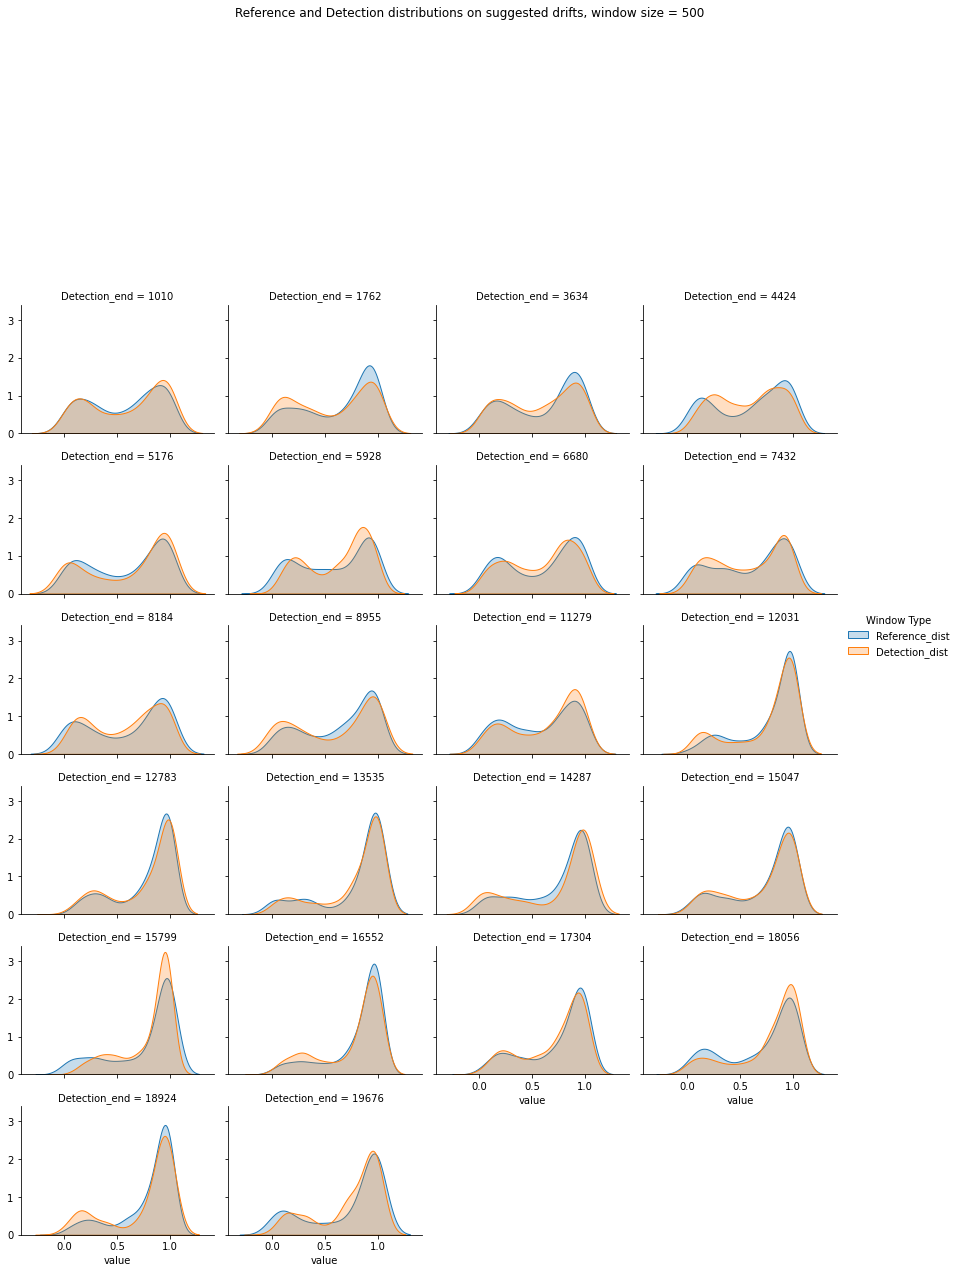

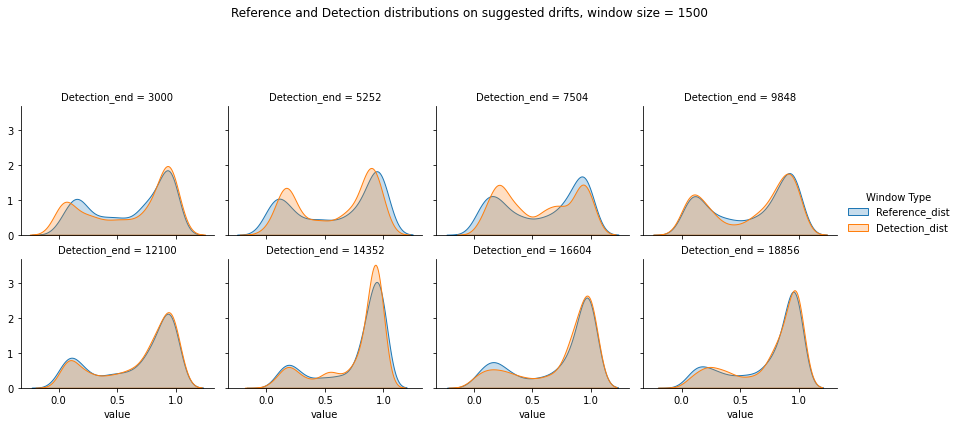

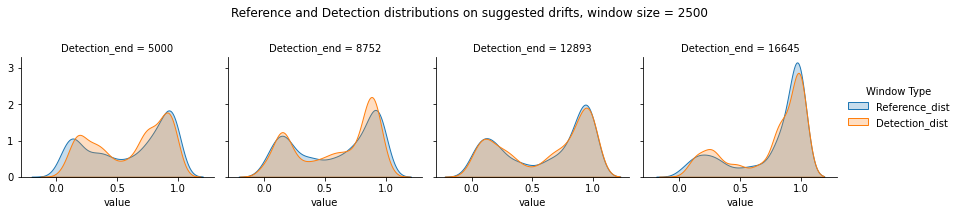

In [6]:
results_KS = pd.read_csv("./results/exp_results/data_SEA_abrupto_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


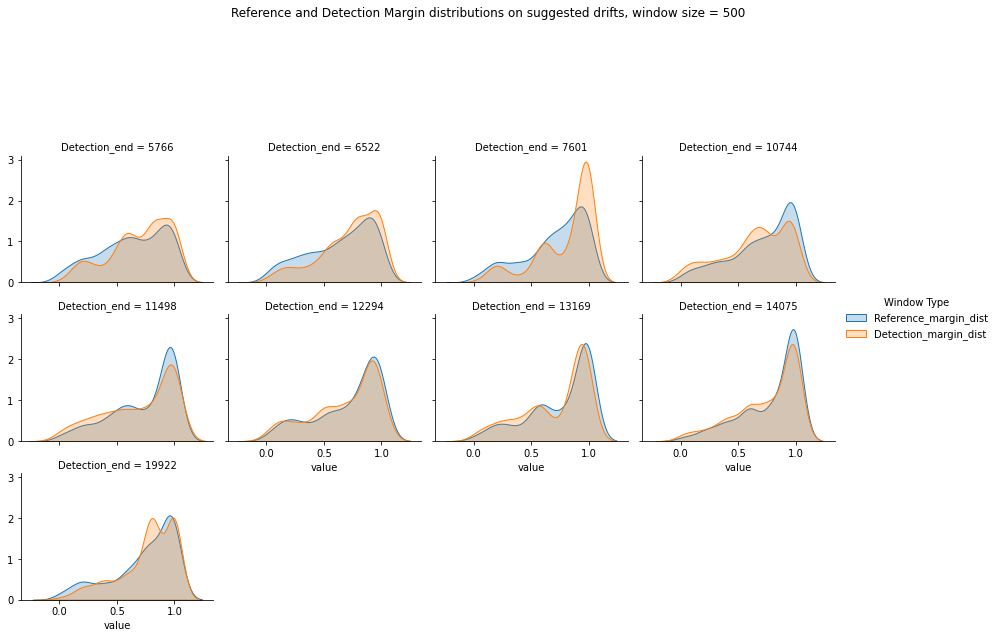

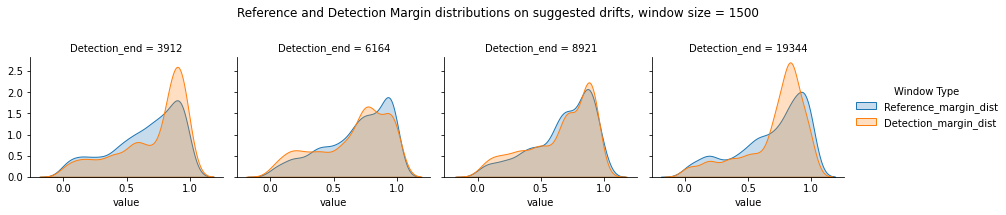

In [7]:
results_XS = pd.read_csv("./results/exp_results/data_SEA_abrupto_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500])

### SEA - recurrente

In [7]:
# Load data
change_points = [5000,10000,15000]

column_mapping = {
    "target": "target",
    "int_features": ["v", "w", "x"],
    "float_features": [],
}

dataset_SEA_rec = pd.read_csv("./datasets/data_SEA_recurrente.csv")
name_ds = "exp_results/data_SEA_recurrente"

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


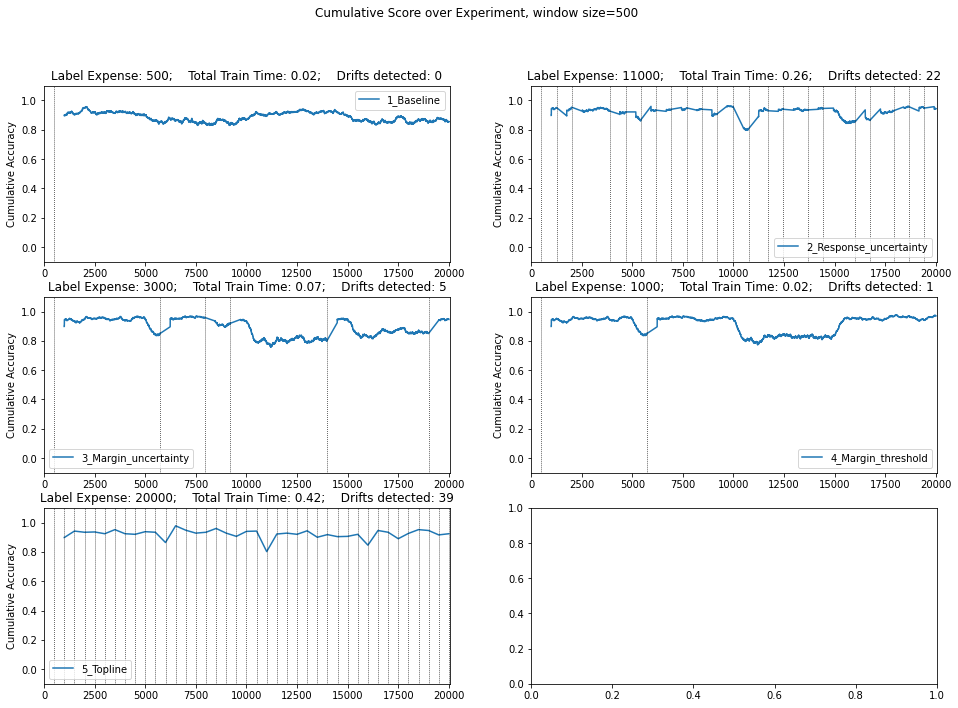

Running experiments with window size = 1500


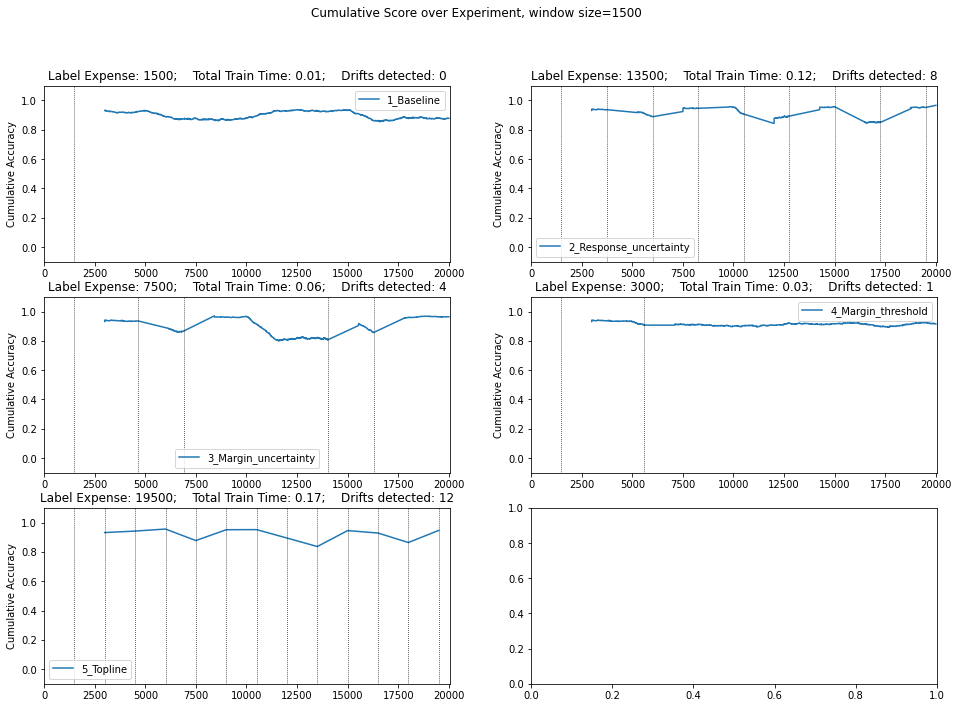

Running experiments with window size = 2500


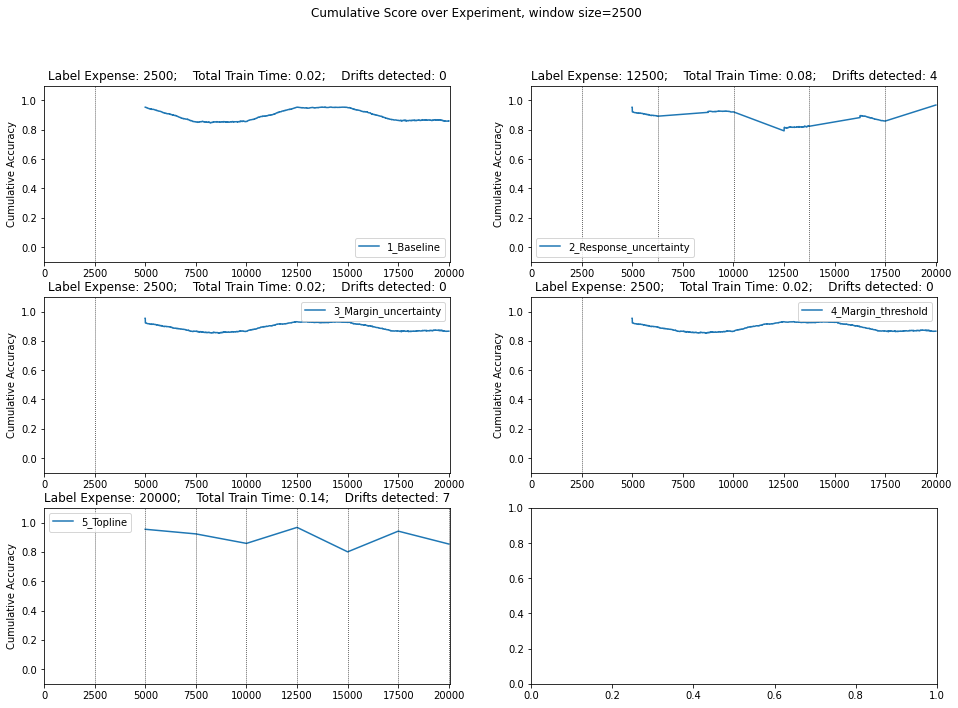

In [9]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500]:
    # Define dataset
    dataset = Dataset(name_ds, full_df=dataset_SEA_rec, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset.window_size}")
    exps = define_run_exps(model, param_grid, dataset, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset.window_size}")
    plt.show()

##### Consolidación de métricas

In [8]:
metrics = []

exps = ["2_Response_uncertainty", "3_Margin_uncertainty", "4_margin_threshold"]

for exp in exps:
    str_res = f"./results/{name_ds}_{exp}_results.csv"
    results = pd.read_csv(str_res, sep=",", low_memory=False)

    for type_eval in ["Strict", "Medium", "Relaxed"]:
        metrics = aggregate_experiment_metrics(metrics, results, change_points, [500, 1500, 2500], type_eval)

pd.DataFrame(metrics).set_index(['Experiment','Evaluation','Window sizes'])

Drift signaled  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                       22   
                                  1500                       8   
                                  2500                       4   
                       Medium     500                       22   
                                  1500                       8   
                                  2500                       4   
                       Relaxed    500                       22   
                                  1500                       8   
                                  2500                       4   
3_Margin_uncertainty   Strict     500                        5   
                                  1500                       4   
                                  2500                       0   
                       Medium     500                        5   
                                  1500                       4   
                                  2500                       0   
                       Relaxed    500                        5   
                                  1500                       4   
                                  2500                       0   
4_Margin_threshold     Strict     500                        1   
                                  1500                       1   
                                  2500                       0   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       0   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       0   

                                                Drift occurred  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Medium     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Relaxed    500                        3   
                                  1500                       3   
                                  2500                       3   
3_Margin_uncertainty   Strict     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Medium     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Relaxed    500                        3   
                                  1500                       3   
                                  2500                       3   
4_Margin_threshold     Strict     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Medium     500                        3   
                                  1500                       3   
                                  2500                       3   
                       Relaxed    500                        3   
                                  1500                       3   
                                  2500                       3   

                                                True positives  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        1   
                    

##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


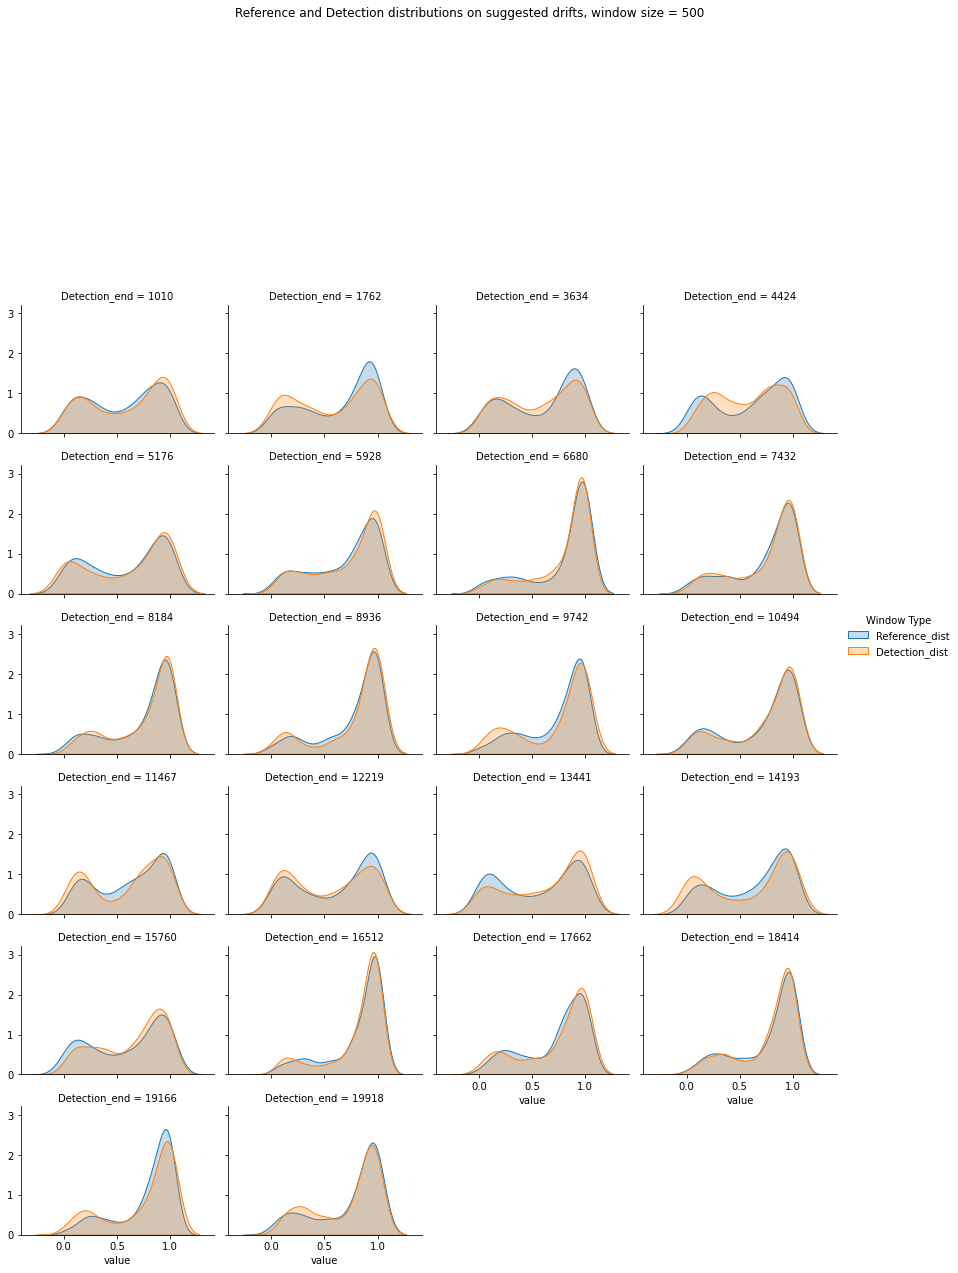

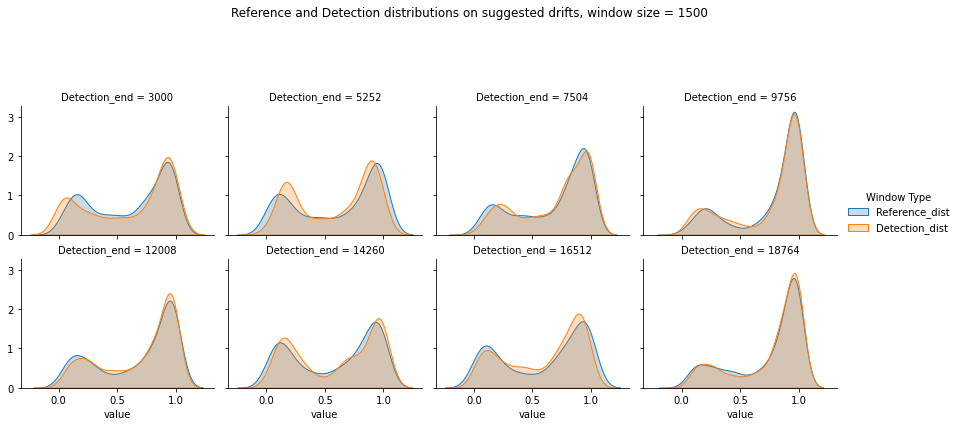

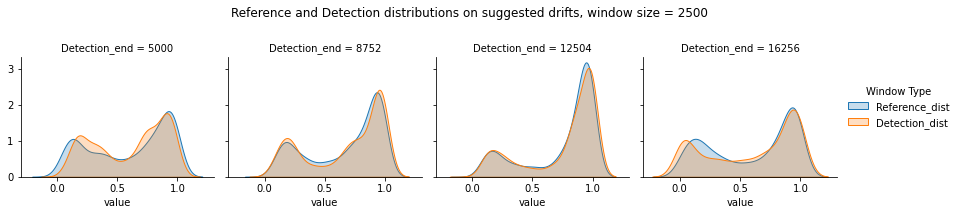

In [10]:
results_KS = pd.read_csv("./results/exp_results/data_SEA_recurrente_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


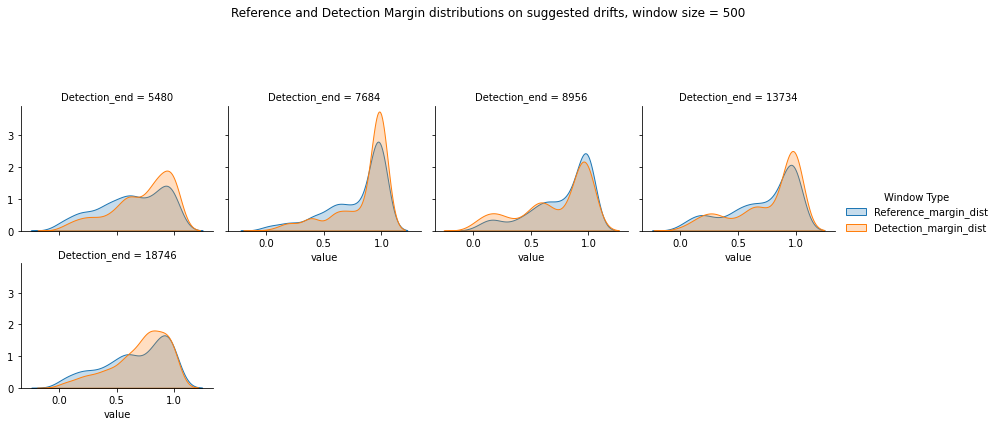

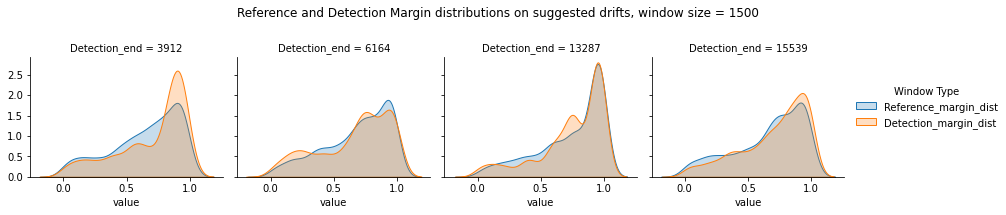

In [11]:
results_XS = pd.read_csv("./results/exp_results/data_SEA_recurrente_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500])

### SEA - Gradual

In [10]:
# Load data
change_points = [9750]

column_mapping = {
    "target": "target",
    "int_features": ["v", "w", "x"],
    "float_features": [],
}

dataset_SEA_grad = pd.read_csv("./datasets/data_SEA_gradual.csv")
name_ds = "exp_results/data_SEA_gradual"

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

Running experiments with window size = 500


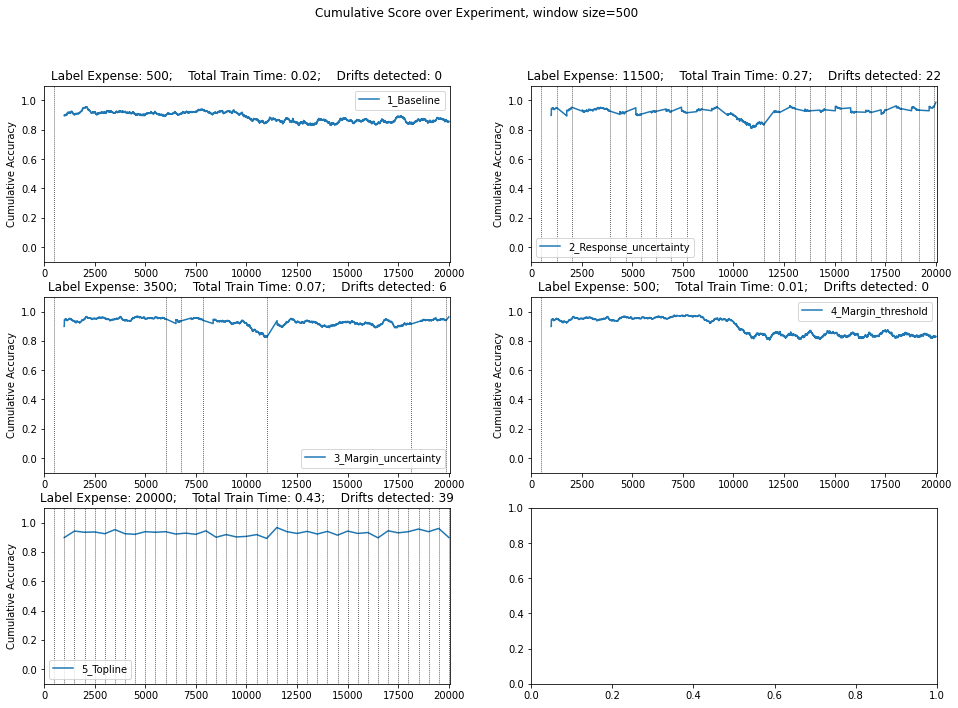

Running experiments with window size = 1500


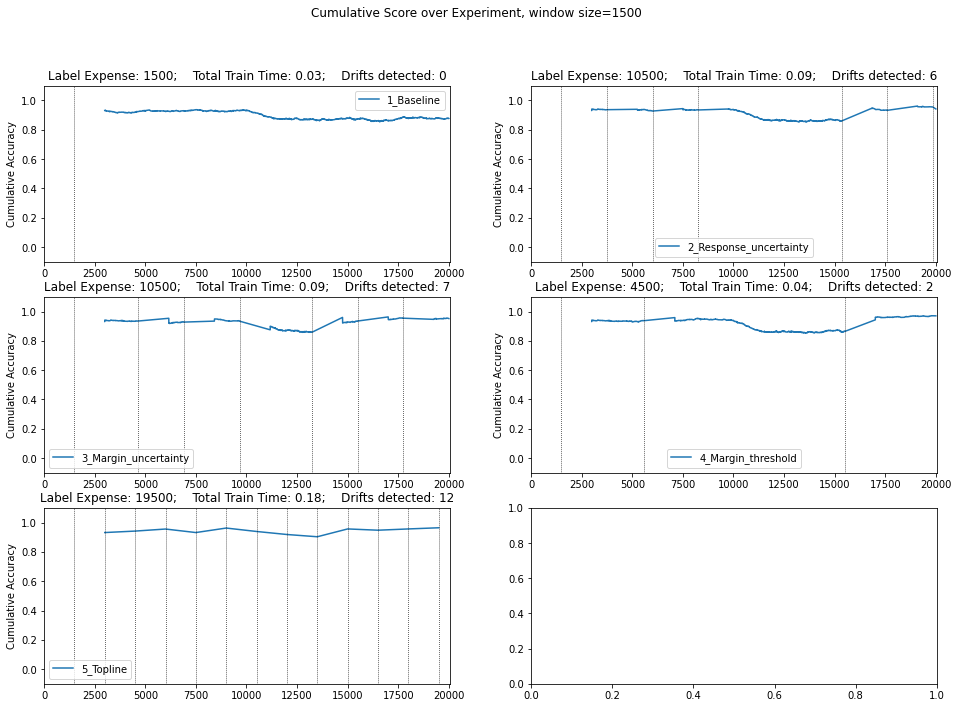

Running experiments with window size = 2500


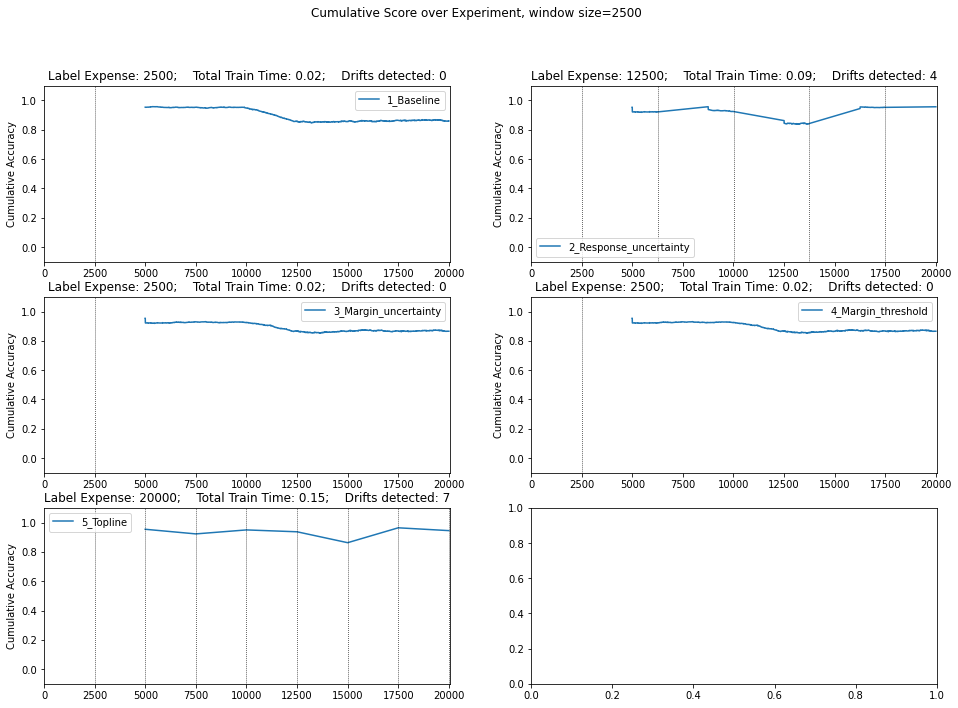

In [13]:
# Run experiments
delete_csv=True
for size_w in [500, 1500, 2500]:
    # Define dataset
    dataset = Dataset(name_ds, full_df=dataset_SEA_grad, column_mapping=column_mapping, window_size=size_w)
    # Run experiments
    print(f"Running experiments with window size = {dataset.window_size}")
    exps = define_run_exps(model, param_grid, dataset, delete_csv=delete_csv)
    delete_csv=False
    #Plot results
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize = (16,11))
    axs = axs.flatten()
    i = 0
    for exp in exps:
        plot_experiment_error(exp, show_trainings=True, ax=axs[i])
        i+=1
    fig.suptitle(f"Cumulative Score over Experiment, window size={dataset.window_size}")
    plt.show()

##### Consolidación de métricas

In [11]:
metrics = []

exps = ["2_Response_uncertainty", "3_Margin_uncertainty", "4_margin_threshold"]

for exp in exps:
    str_res = f"./results/{name_ds}_{exp}_results.csv"
    results = pd.read_csv(str_res, sep=",", low_memory=False)

    for type_eval in ["Strict", "Medium", "Relaxed"]:
        metrics = aggregate_experiment_metrics(metrics, results, change_points, [500, 1500, 2500], type_eval)

pd.DataFrame(metrics).set_index(['Experiment','Evaluation','Window sizes'])

Drift signaled  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                       22   
                                  1500                       6   
                                  2500                       4   
                       Medium     500                       22   
                                  1500                       6   
                                  2500                       4   
                       Relaxed    500                       22   
                                  1500                       6   
                                  2500                       4   
3_Margin_uncertainty   Strict     500                        6   
                                  1500                       7   
                                  2500                       0   
                       Medium     500                        6   
                                  1500                       7   
                                  2500                       0   
                       Relaxed    500                        6   
                                  1500                       7   
                                  2500                       0   
4_Margin_threshold     Strict     500                        0   
                                  1500                       2   
                                  2500                       0   
                       Medium     500                        0   
                                  1500                       2   
                                  2500                       0   
                       Relaxed    500                        0   
                                  1500                       2   
                                  2500                       0   

                                                Drift occurred  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   
3_Margin_uncertainty   Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   
4_Margin_threshold     Strict     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Medium     500                        1   
                                  1500                       1   
                                  2500                       1   
                       Relaxed    500                        1   
                                  1500                       1   
                                  2500                       1   

                                                True positives  \
Experiment             Evaluation Window sizes                   
2_Response_uncertainty Strict     500                        0   
                    

##### Inspección visual de resultados

Visualización de la distribución en las zonas detectadas como drift en Exp 2:


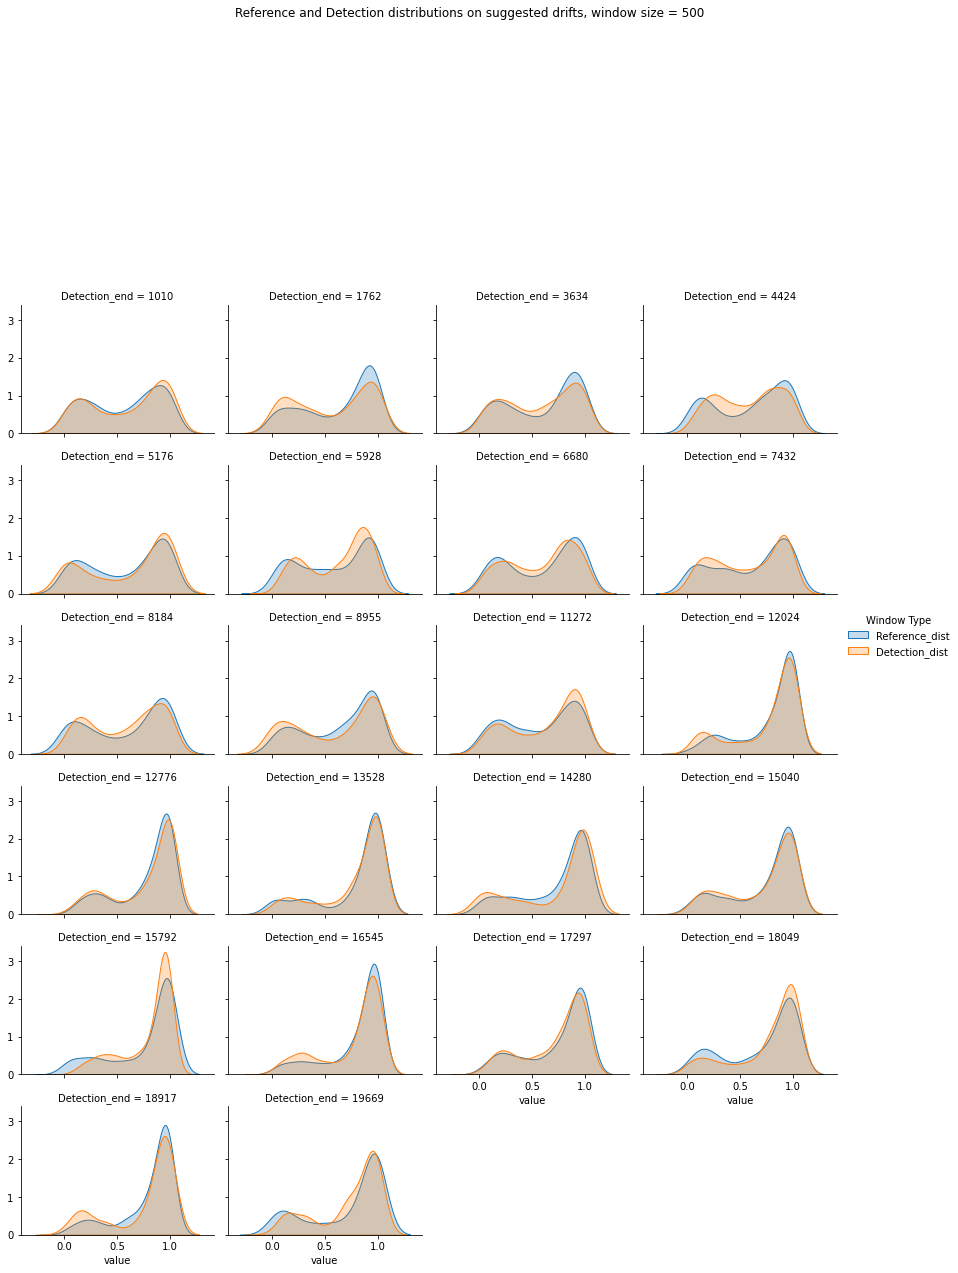

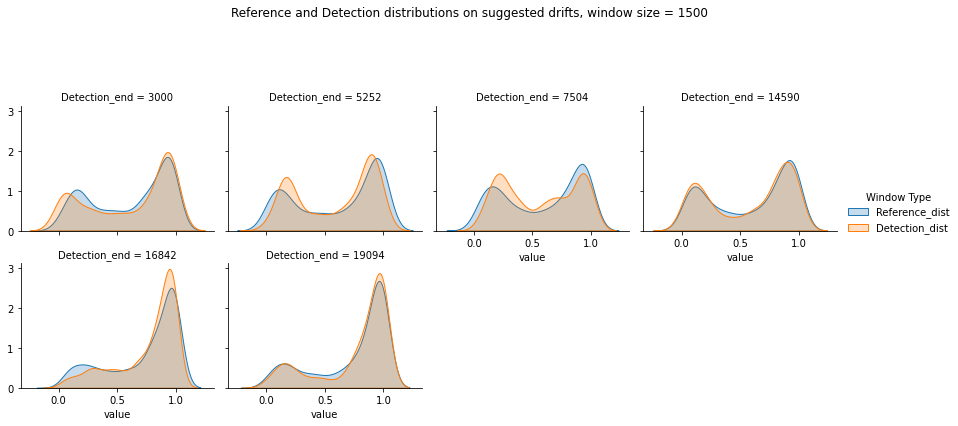

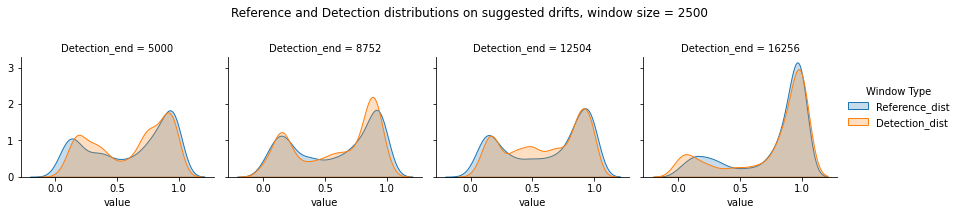

In [14]:
results_KS = pd.read_csv("./results/exp_results/data_SEA_gradual_2_Response_uncertainty_results.csv", sep=",")

print("Visualización de la distribución en las zonas detectadas como drift en Exp 2:")
plot_KS_drift_distributions(results_KS,[500, 1500, 2500])

Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:


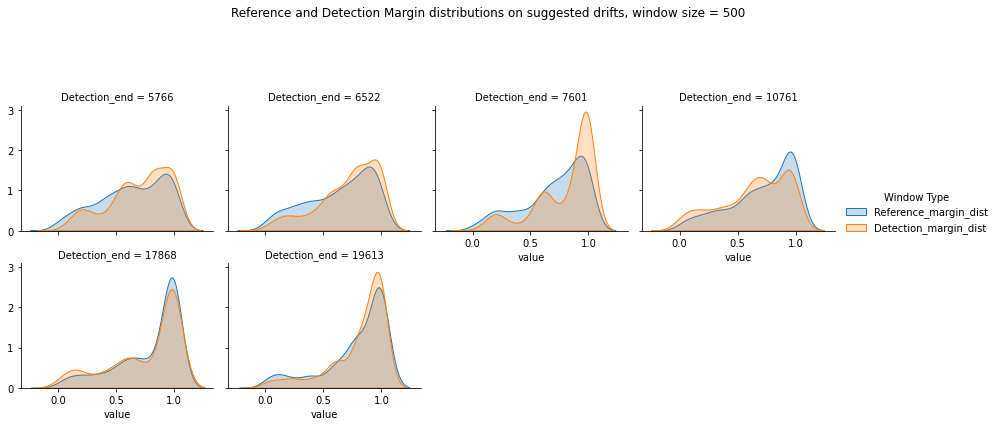

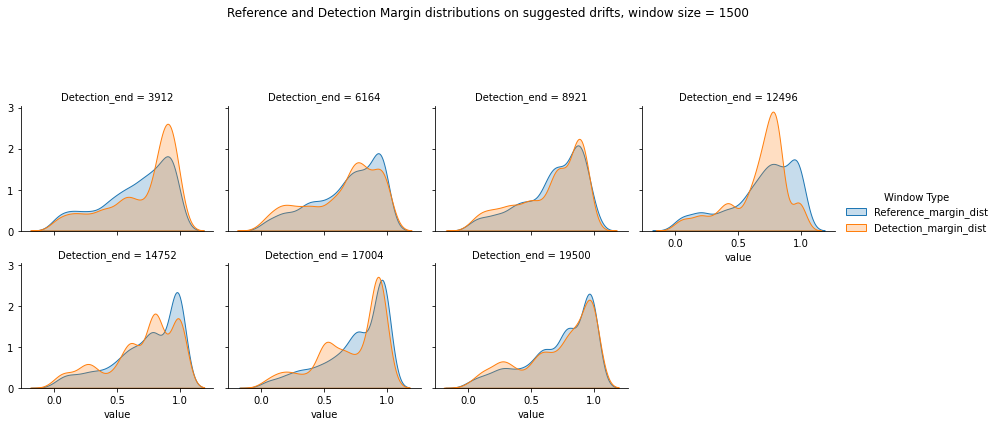

In [15]:
results_XS = pd.read_csv("./results/exp_results/data_SEA_gradual_3_Margin_uncertainty_results.csv", sep=",", low_memory=False)

print("Visualización de la distribución del margen en las zonas detectadas como drift en Exp 3:")
plot_XS_drift_margin_distributions(results_XS, [500, 1500, 2500])